[Edward regression example](http://edwardlib.org/tutorials/supervised-regression)

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import edward as ed
from edward.models import Normal
import seaborn as sns
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

plt.style.use('seaborn')

In [77]:
def build_toy_dataset(N, w):
    D = len(w)
    x = np.random.normal(0.0, 2.0, size=(N, D))
    y = np.dot(x, w) + np.random.normal(0.0, 0.5, size=N)
    return x, y

N = 40  # number of data points
D = 10  # number of features

w_true = np.random.randn(D) * 0.5
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

In [113]:
res = smf.OLS(y_train, sm.add_constant(X_train)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     275.4
Date:                Sun, 25 Mar 2018   Prob (F-statistic):           6.03e-26
Time:                        11:20:34   Log-Likelihood:                -18.343
No. Observations:                  40   AIC:                             58.69
Df Residuals:                      29   BIC:                             77.26
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0186      0.087      0.215      0.831      -0.159       0.196
x1             1.2015      0.038     31.975      0.000       1.125       1.278
x2             0.0976      0.037      2.610      0.014       0.021       0.174
x3            -0.5940      0.052    -11.400      0.000      -0.701      -0.487
x4             0.0231      0.039      0.596      0.556      -0.056       0.102
x5            -0.4879      0.036    -13.633      0.000      -0.561      -0.415
x6            -0.3194      0.037     -8.581      0.000      -0.396      -0.243
x7             1.0135      0.048     21.045      0.000       0.915       1.112
x8             0.4579      0.041     11.206      0.000       0.374       0.541
x9             0.6627      0.038     17.288      0.000       0.584       0.741
x10           -0.3642      0.033    -10.883      0.000      -0.433      -0.296
==============================================================================
Omnibus:                        1.121   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.571   Jarque-Bera (JB):                0.922
Skew:                          -0.082   Prob(JB):                        0.631
Kurtosis:                       2.274   Cond. No.                         3.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

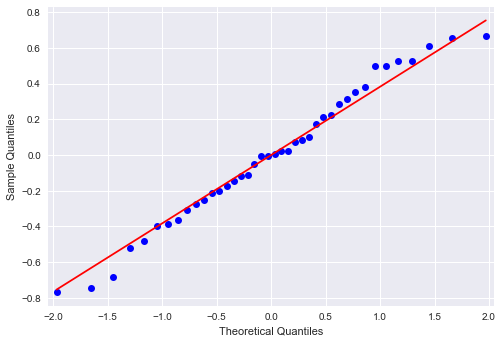

In [114]:
sm.qqplot(res.resid, line='s');

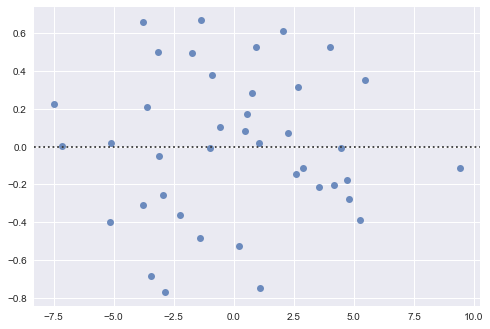

In [115]:
sns.residplot(res.fittedvalues, y_train);

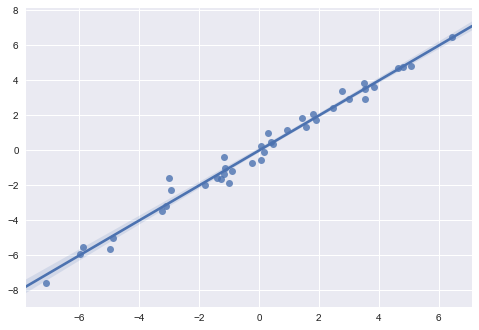

In [117]:
sns.regplot(res.predict(sm.add_constant(X_test)), y_test);

In [118]:
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))

In [119]:
qw = Normal(loc=tf.get_variable("qw/loc", [D]),
            scale=tf.nn.softplus(tf.get_variable("qw/scale", [D])))
qb = Normal(loc=tf.get_variable("qb/loc", [1]),
            scale=tf.nn.softplus(tf.get_variable("qb/scale", [1])))

ValueError: Variable qw/loc already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "C:\Users\emman\Miniconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access
  File "C:\Users\emman\Miniconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3271, in create_op
    op_def=op_def)
  File "C:\Users\emman\Miniconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)


In [120]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

C:\Users\emman\Miniconda3\lib\site-packages\edward\util\random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


250/250 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 72.439


In [121]:
y_post = ed.copy(y, {w: qw, b: qb})

In [122]:
(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}),
ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

C:\Users\emman\Miniconda3\lib\site-packages\edward\util\random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


(0.21879883, 0.3433333)

In [133]:
qw.mean().eval()

array([ 1.1996801 ,  0.10990144, -0.6256982 ,  0.04127824, -0.52722263,
       -0.3379056 ,  1.0052722 ,  0.4206545 ,  0.61087805, -0.35406744],
      dtype=float32)

In [136]:
qb.mean().eval()

array([0.01259988], dtype=float32)

In [137]:
res.params

array([ 0.01859952,  1.20151387,  0.09763754, -0.59398198,  0.02308477,
       -0.4878896 , -0.31944998,  1.01350953,  0.45786463,  0.66265173,
       -0.36423518])

Compare with regularized least squares.